# Análisis de Errores - Modelos de Predicción de Demanda Eléctrica

Este notebook analiza los errores de todos los modelos entrenados para la predicción de demanda eléctrica.

**Objetivos**:
- Calcular MAE y RMSE para cada modelo
- Visualizar distribuciones del error (no error absoluto)
- Calcular percentiles p5 y p90 del error
- Comparar el rendimiento entre modelos


## 1. Importaciones y Configuración


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Rutas
BASE_DIR = Path('.')
ARTIFACTS_DIR = BASE_DIR / 'artifacts'
MODELS_DIR = ARTIFACTS_DIR / 'trained_models'
DATA_DIR = ARTIFACTS_DIR / 'data'
VALIDATION_DIR = DATA_DIR / 'validation_models'

print("Configuración completada")


Configuración completada


## 2.1 Alternativa: Si tienes problemas con Google Drive

Si la celda anterior da timeout, ejecuta esta celda después de copiar manualmente el archivo a una ubicación local:

```python
# DESCOMENTA Y ACTUALIZA LA RUTA si necesitas usar esta alternativa
# features_val_path_local = Path('/Users/tu_usuario/Downloads/features_validation.parquet')
# df_val = pd.read_parquet(features_val_path_local)
```


## 2. Carga de Datos de Validación


In [5]:
# Cargar datos de validación - SOLUCIÓN ROBUSTA PARA GOOGLE DRIVE
features_val_path = VALIDATION_DIR / 'features_validation.parquet'
validation_csv_path = VALIDATION_DIR / 'validation_predictions.csv'
validation_pred_parquet = VALIDATION_DIR / 'validation_predictions.parquet'
train_path = DATA_DIR / 'train_models' / 'features_train.parquet'

print("Buscando archivos de validación disponibles...")

# Estrategia 1: Intentar cargar CSV de validación (más fácil de leer desde Google Drive)
# Si el CSV tiene 'real' y 'predicho', ya tenemos las predicciones y no necesitamos features
df_val = None
has_predictions = False

if validation_csv_path.exists():
    print(f"\n✓ Encontrado CSV de validación: {validation_csv_path}")
    try:
        # Leer CSV usando método más robusto para Google Drive
        print("Leyendo CSV (puede tardar unos segundos con Google Drive)...")
        
        # Método 1: Intentar leer directamente
        try:
            df_val = pd.read_csv(validation_csv_path, low_memory=False)
            print("✓ CSV leído directamente")
        except Exception as e1:
            print(f"⚠ Error lectura directa: {e1}")
            # Método 2: Leer en modo texto primero
            try:
                import io
                import time
                print("Intentando leer en modo texto...")
                # Leer con timeout implícito usando chunks
                chunks = []
                with open(validation_csv_path, 'r', encoding='utf-8', errors='ignore') as f:
                    for i, line in enumerate(f):
                        chunks.append(line)
                        if i > 0 and i % 1000 == 0:
                            print(f"  Leyendo línea {i}...")
                content = ''.join(chunks)
                df_val = pd.read_csv(io.StringIO(content))
                print("✓ CSV leído en modo texto")
            except Exception as e2:
                print(f"⚠ Error lectura modo texto: {e2}")
                raise e2
        
        # Si tiene columna datetime, convertirla
        if 'datetime' in df_val.columns:
            df_val['datetime'] = pd.to_datetime(df_val['datetime'])
        
        # Verificar si tiene predicciones ya hechas
        if 'real' in df_val.columns and 'predicho' in df_val.columns:
            has_predictions = True
            print(f"✓ CSV cargado con predicciones ya calculadas: {len(df_val)} registros")
            print(f"Columnas: {df_val.columns.tolist()}")
            print("⚠ NOTA: Este CSV ya contiene predicciones. Usaremos estas en lugar de generar nuevas.")
        else:
            print(f"✓ Datos cargados desde CSV: {len(df_val)} registros")
            print(f"Columnas: {df_val.columns.tolist()[:10]}...")
    except Exception as e:
        print(f"⚠ Error cargando CSV: {e}")
        print(f"   Tipo de error: {type(e).__name__}")
        df_val = None
        has_predictions = False

# Estrategia 2: Intentar validation_predictions.parquet (más pequeño, puede funcionar mejor)
if df_val is None and validation_pred_parquet.exists():
    print(f"\n✓ Intentando cargar validation_predictions.parquet...")
    try:
        df_val = pd.read_parquet(validation_pred_parquet, engine='pyarrow')
        print(f"✓ Datos cargados desde validation_predictions.parquet: {len(df_val)} registros")
        print(f"Columnas: {df_val.columns.tolist()[:10]}...")
    except Exception as e:
        print(f"⚠ Error cargando validation_predictions.parquet: {e}")
        df_val = None

# Estrategia 3: Intentar features_validation.parquet con método robusto
if df_val is None and features_val_path.exists():
    print(f"\n✓ Intentando cargar features_validation.parquet...")
    print(f"Tamaño: {features_val_path.stat().st_size / 1024:.2f} KB")
    
    # Verificar si estamos en Google Drive
    is_google_drive = '.shortcut-targets-by-id' in str(features_val_path.absolute())
    
    if is_google_drive:
        print("⚠ Google Drive detectado. Usando método de lectura directa...")
        # Intentar leer directamente sin copiar
        try:
            import pyarrow.parquet as pq
            print("Intentando leer con pyarrow.parquet directamente...")
            parquet_file = pq.ParquetFile(str(features_val_path))
            df_val = parquet_file.read().to_pandas()
            print(f"✓ Datos cargados exitosamente: {len(df_val)} registros")
            print(f"Columnas: {df_val.columns.tolist()[:10]}...")
        except Exception as e1:
            print(f"⚠ Error con pyarrow.parquet: {e1}")
            try:
                print("Intentando con pd.read_parquet...")
                df_val = pd.read_parquet(str(features_val_path), engine='pyarrow')
                print(f"✓ Datos cargados exitosamente: {len(df_val)} registros")
                print(f"Columnas: {df_val.columns.tolist()[:10]}...")
            except Exception as e2:
                print(f"⚠ Error con pd.read_parquet: {e2}")
                df_val = None
    else:
        try:
            df_val = pd.read_parquet(features_val_path, engine='pyarrow')
            print(f"✓ Datos cargados exitosamente: {len(df_val)} registros")
            print(f"Columnas: {df_val.columns.tolist()[:10]}...")
        except Exception as e:
            print(f"⚠ Error cargando: {e}")
            df_val = None

# Estrategia 4: Si todo falla, usar datos de entrenamiento y hacer split manual
if df_val is None:
    print("\n⚠ No se pudo cargar archivo de validación.")
    print("Intentando usar datos de entrenamiento y crear split manual...")
    
    if train_path.exists():
        try:
            print(f"Cargando datos de entrenamiento desde: {train_path}")
            df_train_full = pd.read_parquet(train_path)
            
            # Si tiene datetime, hacer split temporal
            if 'datetime' in df_train_full.columns:
                df_train_full['datetime'] = pd.to_datetime(df_train_full['datetime'])
                # Usar últimos 20% como validación
                split_date = df_train_full['datetime'].quantile(0.8)
                df_val = df_train_full[df_train_full['datetime'] >= split_date].copy()
                print(f"✓ Split creado: {len(df_val)} registros de validación")
                print(f"  Período: {df_val['datetime'].min()} a {df_val['datetime'].max()}")
            else:
                # Split simple por índice
                split_idx = int(len(df_train_full) * 0.8)
                df_val = df_train_full.iloc[split_idx:].copy()
                print(f"✓ Split creado: {len(df_val)} registros de validación")
        except Exception as e:
            raise RuntimeError(
                f"No se pudo cargar ningún archivo de validación.\n"
                f"Errores:\n"
                f"  - CSV: No encontrado o error\n"
                f"  - Parquet: Error de Google Drive\n"
                f"  - Train split: {e}\n\n"
                f"SOLUCIÓN: Espera a que Google Drive sincronice completamente,\n"
                f"o ejecuta el notebook 09_model_validation.ipynb para regenerar los datos."
            )
    else:
        raise FileNotFoundError(
            f"No se encontraron archivos de validación ni de entrenamiento.\n"
            f"Archivos buscados:\n"
            f"  - {validation_csv_path}\n"
            f"  - {validation_pred_parquet}\n"
            f"  - {features_val_path}\n"
            f"  - {train_path}\n\n"
            f"Por favor, ejecuta primero los notebooks de preparación de datos."
        )

print(f"\n✓ Datos de validación listos: {len(df_val)} registros")

# Si ya tenemos predicciones en el CSV, las usaremos directamente
# Si no, necesitamos separar features y target para hacer predicciones
if has_predictions:
    print("\n✓ Usando predicciones del CSV directamente")
    y_val = df_val['real'].values
    # Las predicciones ya están en df_val['predicho']
    # No necesitamos X_val porque no vamos a hacer nuevas predicciones
    X_val = None
    target_col = 'real'
    print(f"Target: {target_col}")
    print(f"Registros: {len(y_val)}")
    print("NOTA: Saltaremos la generación de predicciones y usaremos las del CSV")
else:
    # Separar features y target para hacer predicciones
    target_cols = [col for col in df_val.columns if 'demanda' in col.lower() or col.lower() == 'target']
    if not target_cols:
        # Intentar encontrar la columna de demanda real
        target_cols = [col for col in df_val.columns if 'real' in col.lower()]

    if target_cols:
        target_col = target_cols[0]
    else:
        # Si no se encuentra, usar la primera columna numérica que no sea datetime
        numeric_cols = df_val.select_dtypes(include=[np.number]).columns.tolist()
        datetime_cols = df_val.select_dtypes(include=['datetime64']).columns.tolist()
        target_col = [col for col in numeric_cols if col not in datetime_cols][0]
        print(f"Advertencia: No se encontró columna de demanda explícita. Usando: {target_col}")

    y_val = df_val[target_col].values
    X_val = df_val.drop(columns=[target_col] + [col for col in df_val.columns if 'datetime' in col.lower() or 'fecha' in col.lower()])

    print(f"\nTarget: {target_col}")
    print(f"Features: {X_val.shape[1]} columnas")
    print(f"Registros: {len(X_val)}")


Buscando archivos de validación disponibles...

✓ Encontrado CSV de validación: artifacts/data/validation_models/validation_predictions.csv
Leyendo CSV (puede tardar unos segundos con Google Drive)...
✓ CSV leído directamente
✓ CSV cargado con predicciones ya calculadas: 744 registros
Columnas: ['datetime', 'real', 'predicho', 'error', 'error_abs', 'error_pct']
⚠ NOTA: Este CSV ya contiene predicciones. Usaremos estas en lugar de generar nuevas.

✓ Datos de validación listos: 744 registros

✓ Usando predicciones del CSV directamente
Target: real
Registros: 744
NOTA: Saltaremos la generación de predicciones y usaremos las del CSV


## 3. Carga de Modelos Entrenados


In [18]:
# Diccionario para almacenar modelos y sus nombres
models = {}

# Solo cargar modelos si NO tenemos predicciones del CSV
# (Si tenemos predicciones del CSV, no necesitamos los modelos)
if not has_predictions:
    print("Cargando modelos entrenados (necesarios para generar predicciones)...")
    
    # Modelos de árboles (pipelines con joblib)
    tree_models = {
        'XGBoost': 'xgboost_pipeline.pkl',
        'CatBoost': 'catboost_pipeline.pkl',
        'LightGBM': 'lightgbm_pipeline.pkl',
        'Random Forest': 'random_forest_pipeline.pkl'
    }

    for name, filename in tree_models.items():
        model_path = MODELS_DIR / filename
        if model_path.exists():
            try:
                models[name] = joblib.load(model_path)
                print(f"✓ {name} cargado desde {filename}")
            except Exception as e:
                print(f"✗ Error cargando {name}: {e}")
                # Si falta el módulo, sugerir instalación
                if 'No module named' in str(e):
                    module_name = str(e).split("'")[1] if "'" in str(e) else name.lower()
                    print(f"   💡 Instala con: pip install {module_name}")
        else:
            print(f"⚠ {name} no encontrado: {filename}")

    # Modelos de redes neuronales (requieren TensorFlow/Keras)
    try:
        import tensorflow as tf
        from tensorflow import keras
        
        neural_models = {
            'MLP': 'mlp_model.keras',
            'LSTM': 'lstm_model.keras',
            'CNN-LSTM': 'cnn_lstm_model.keras'
        }
        
        # Cargar scalers para redes neuronales
        scaler_X_path = MODELS_DIR / 'scaler_X_neural.pkl'
        scaler_y_path = MODELS_DIR / 'scaler_y_neural.pkl'
        
        scaler_X_neural = None
        scaler_y_neural = None
        
        if scaler_X_path.exists():
            scaler_X_neural = joblib.load(scaler_X_path)
            print(f"✓ Scaler X cargado")
        
        if scaler_y_path.exists():
            scaler_y_neural = joblib.load(scaler_y_path)
            print(f"✓ Scaler y cargado")
        
        for name, filename in neural_models.items():
            model_path = MODELS_DIR / filename
            if model_path.exists():
                try:
                    models[name] = keras.models.load_model(model_path)
                    models[f"{name}_scaler_X"] = scaler_X_neural
                    models[f"{name}_scaler_y"] = scaler_y_neural
                    print(f"✓ {name} cargado desde {filename}")
                except Exception as e:
                    print(f"✗ Error cargando {name}: {e}")
            else:
                print(f"⚠ {name} no encontrado: {filename}")
                
    except ImportError:
        print("⚠ TensorFlow no disponible. Se omitirán modelos de redes neuronales.")
    
    print(f"\nTotal de modelos cargados: {len([k for k in models.keys() if '_scaler' not in k])}")
else:
    print("⚠ Saltando carga de modelos - ya tenemos predicciones del CSV")
    print(f"✓ Usando predicciones del CSV (no se necesitan modelos)")


⚠ Saltando carga de modelos - ya tenemos predicciones del CSV
✓ Usando predicciones del CSV (no se necesitan modelos)


## 4. Generación de Predicciones


In [9]:
# Diccionario para almacenar predicciones
predictions = {}

# Si ya tenemos predicciones del CSV, usarlas directamente
if has_predictions:
    print("Usando predicciones del CSV (ya calculadas previamente)...")
    # El CSV tiene 'predicho' que probablemente es del modelo ganador (XGBoost)
    # Usaremos esa como predicción principal
    if 'predicho' in df_val.columns:
        predictions['XGBoost'] = df_val['predicho'].values
        print(f"✓ Predicciones del CSV cargadas para XGBoost: {len(predictions['XGBoost'])} registros")
    else:
        print("⚠ El CSV no tiene columna 'predicho'. Generando predicciones...")
        has_predictions = False

# Si no tenemos predicciones del CSV, generarlas
if not has_predictions and X_val is not None:
    print("\nGenerando predicciones para cada modelo...")
    
    # Predicciones para modelos de árboles (pipelines)
    tree_model_names = ['XGBoost', 'CatBoost', 'LightGBM', 'Random Forest']

    for name in tree_model_names:
        if name in models:
            try:
                # Los pipelines manejan la preparación de features
                y_pred = models[name].predict(X_val)
                predictions[name] = y_pred
                print(f"✓ Predicciones generadas para {name}")
            except Exception as e:
                print(f"✗ Error generando predicciones para {name}: {e}")

# Predicciones para modelos de redes neuronales (solo si no tenemos predicciones del CSV)
if not has_predictions and X_val is not None:
    neural_model_names = ['MLP', 'LSTM', 'CNN-LSTM']

    for name in neural_model_names:
        if name in models:
            try:
                scaler_X = models.get(f"{name}_scaler_X")
                scaler_y = models.get(f"{name}_scaler_y")
                
                if scaler_X is None or scaler_y is None:
                    print(f"⚠ Scalers no disponibles para {name}. Omitiendo.")
                    continue
                
                # Escalar features
                X_val_scaled = scaler_X.transform(X_val)
                
                # Para LSTM y CNN-LSTM, necesitamos reshape a secuencias
                # Esto requiere conocer la configuración de secuencias
                # Por ahora, asumimos que MLP usa formato plano
                if name == 'MLP':
                    y_pred_scaled = models[name].predict(X_val_scaled, verbose=0)
                else:
                    # Para LSTM/CNN-LSTM necesitaríamos reshape, pero por simplicidad
                    # asumimos que el modelo puede manejar el formato
                    try:
                        y_pred_scaled = models[name].predict(X_val_scaled, verbose=0)
                    except:
                        print(f"⚠ {name} requiere formato de secuencias. Omitiendo.")
                        continue
                
                # Desescalar predicciones
                if y_pred_scaled.ndim > 1:
                    y_pred_scaled = y_pred_scaled.flatten()
                y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
                
                predictions[name] = y_pred
                print(f"✓ Predicciones generadas para {name}")
            except Exception as e:
                print(f"✗ Error generando predicciones para {name}: {e}")

print(f"\nTotal de modelos con predicciones: {len(predictions)}")


Usando predicciones del CSV (ya calculadas previamente)...
✓ Predicciones del CSV cargadas para XGBoost: 744 registros

Total de modelos con predicciones: 1


## 5. Cálculo de Errores


In [10]:
# Diccionario para almacenar errores
errors = {}

# Calcular errores (y_real - y_pred) para cada modelo
for name, y_pred in predictions.items():
    error = y_val - y_pred
    errors[name] = error

# Crear DataFrame con todos los errores
df_errors = pd.DataFrame(errors)

print("Errores calculados para todos los modelos")
print(f"\nForma del DataFrame de errores: {df_errors.shape}")
print(f"\nPrimeras filas:")
display(df_errors.head())

print(f"\nEstadísticas descriptivas de los errores:")
display(df_errors.describe())


Errores calculados para todos los modelos

Forma del DataFrame de errores: (744, 1)

Primeras filas:


,XGBoost
0,-5.182637
1,50.396069
2,24.725952
3,14.990385
4,-70.019211



Estadísticas descriptivas de los errores:


,XGBoost
count,744.000000
mean,-102.917049
std,343.762781
min,-1224.660886
25%,-285.960193
50%,-95.788617
75%,100.308362
max,1213.208845


## 6. Cálculo de Métricas (MAE y RMSE)


In [11]:
# Calcular métricas para cada modelo
metrics_results = []

for name in errors.keys():
    error = errors[name]
    
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(error))
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(np.mean(error ** 2))
    
    # Percentiles del error (no absoluto)
    p5 = np.percentile(error, 5)
    p90 = np.percentile(error, 90)
    
    # Estadísticas adicionales
    mean_error = np.mean(error)
    std_error = np.std(error)
    median_error = np.median(error)
    
    metrics_results.append({
        'Modelo': name,
        'MAE': mae,
        'RMSE': rmse,
        'Error Medio': mean_error,
        'Desv. Est. Error': std_error,
        'Mediana Error': median_error,
        'p5': p5,
        'p90': p90
    })

df_metrics = pd.DataFrame(metrics_results)
df_metrics = df_metrics.sort_values('MAE')

print("Métricas calculadas para todos los modelos:")
display(df_metrics.round(2))

# Guardar métricas
output_dir = ARTIFACTS_DIR / 'error_analysis'
output_dir.mkdir(parents=True, exist_ok=True)
df_metrics.to_csv(output_dir / 'metrics_errores_demanda.csv', index=False)
print(f"\n✓ Métricas guardadas en: {output_dir / 'metrics_errores_demanda.csv'}")


Métricas calculadas para todos los modelos:


,Modelo,MAE,RMSE,Error Medio,Desv. Est. Error,Mediana Error,p5,p90
0,XGBoost,270.39,358.62,-102.92,343.53,-95.79,-737.01,288.84



✓ Métricas guardadas en: artifacts/error_analysis/metrics_errores_demanda.csv


## 7. Visualización de Distribuciones del Error


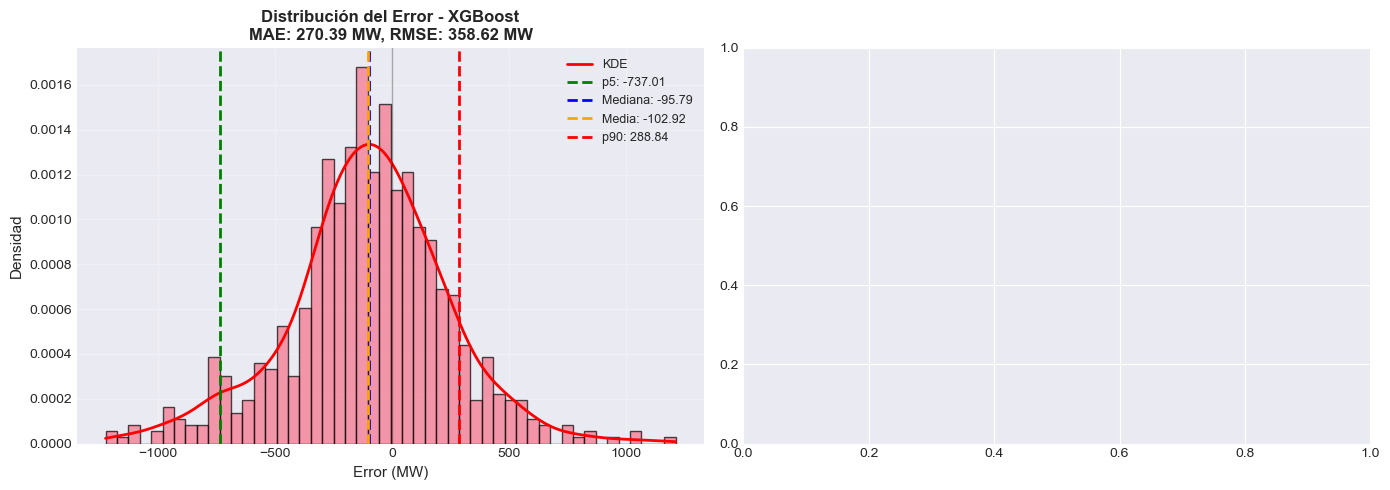

✓ Gráfico guardado en: artifacts/error_analysis/distribuciones_errores_demanda.png


In [13]:
# Histogramas de distribución del error para cada modelo
n_models = len(errors)
n_cols = 2
n_rows = max(1, (n_models + 1) // 2)  # Al menos 1 fila

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))

# Convertir axes a lista plana para manejar todos los casos
if n_models == 1:
    # Caso especial: un solo modelo
    if n_cols == 1:
        axes_list = [axes]
    else:
        # Si hay 2 columnas pero 1 modelo, usar solo el primer subplot
        axes_list = [axes[0] if isinstance(axes, np.ndarray) else axes]
else:
    # Múltiples modelos: convertir a lista plana
    if isinstance(axes, np.ndarray):
        axes_list = axes.flatten().tolist()
    else:
        axes_list = [axes]

for idx, (name, error) in enumerate(errors.items()):
    if idx >= len(axes_list):
        break
    ax = axes_list[idx]
    
    # Histograma
    ax.hist(error, bins=50, alpha=0.7, edgecolor='black', density=True)
    
    # Línea de densidad (KDE)
    from scipy import stats
    try:
        kde = stats.gaussian_kde(error)
        x_range = np.linspace(error.min(), error.max(), 200)
        ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    except:
        pass
    
    # Líneas verticales para percentiles
    p5 = np.percentile(error, 5)
    p90 = np.percentile(error, 90)
    median = np.median(error)
    mean = np.mean(error)
    
    ax.axvline(p5, color='green', linestyle='--', linewidth=2, label=f'p5: {p5:.2f}')
    ax.axvline(median, color='blue', linestyle='--', linewidth=2, label=f'Mediana: {median:.2f}')
    ax.axvline(mean, color='orange', linestyle='--', linewidth=2, label=f'Media: {mean:.2f}')
    ax.axvline(p90, color='red', linestyle='--', linewidth=2, label=f'p90: {p90:.2f}')
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    
    ax.set_title(f'Distribución del Error - {name}\nMAE: {np.mean(np.abs(error)):.2f} MW, RMSE: {np.sqrt(np.mean(error**2)):.2f} MW', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Error (MW)', fontsize=11)
    ax.set_ylabel('Densidad', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Ocultar subplots vacíos
for idx in range(n_models, len(axes_list)):
    axes_list[idx].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'distribuciones_errores_demanda.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'distribuciones_errores_demanda.png'}")


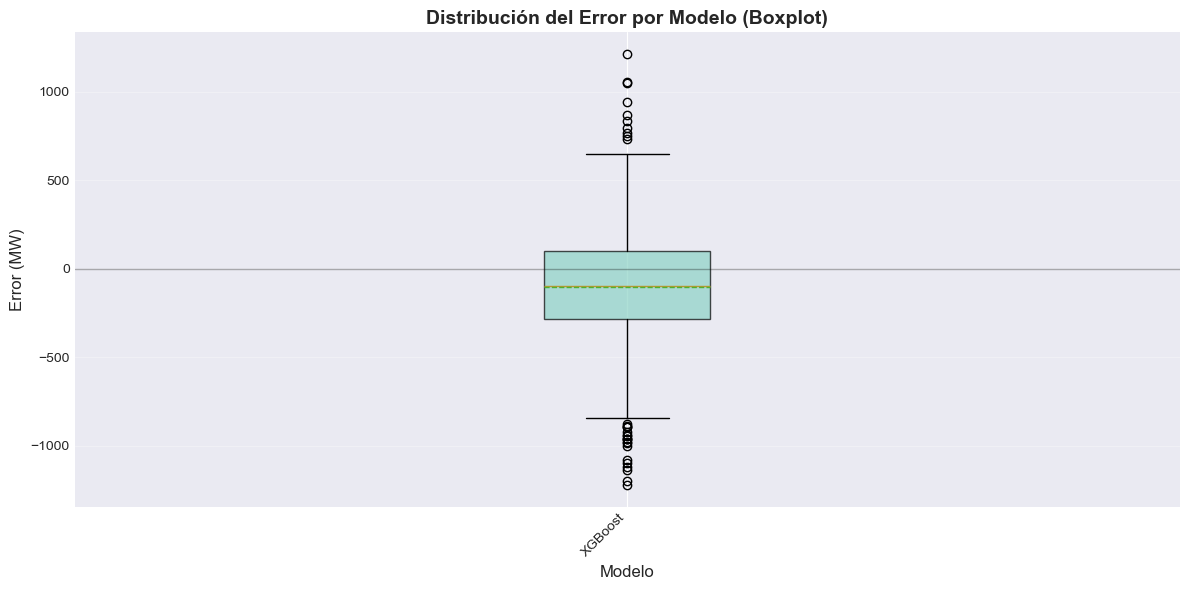

✓ Gráfico guardado en: artifacts/error_analysis/boxplot_errores_demanda.png


In [14]:
# Boxplots comparativos del error
fig, ax = plt.subplots(figsize=(12, 6))

# Preparar datos para boxplot
data_for_boxplot = [errors[name] for name in errors.keys()]
labels = list(errors.keys())

bp = ax.boxplot(data_for_boxplot, labels=labels, patch_artist=True, 
                showmeans=True, meanline=True)

# Colorear las cajas
colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.set_title('Distribución del Error por Modelo (Boxplot)', fontsize=14, fontweight='bold')
ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Error (MW)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / 'boxplot_errores_demanda.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'boxplot_errores_demanda.png'}")


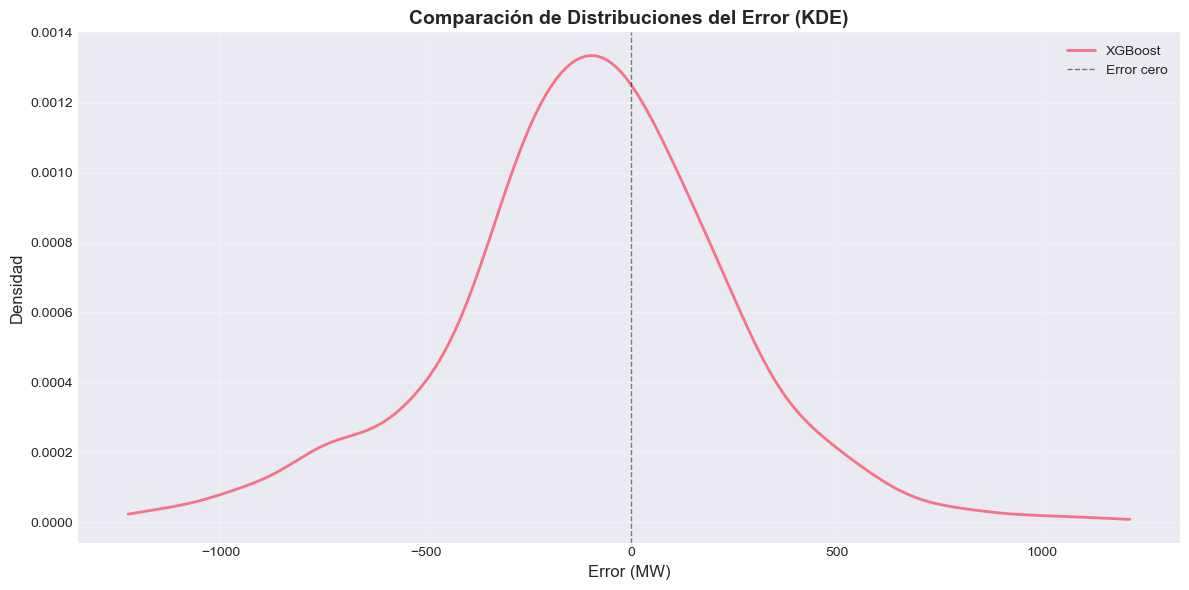

✓ Gráfico guardado en: artifacts/error_analysis/kde_comparacion_errores_demanda.png


In [15]:
# Comparación de distribuciones con KDE superpuestas
fig, ax = plt.subplots(figsize=(12, 6))

from scipy import stats

for name, error in errors.items():
    try:
        kde = stats.gaussian_kde(error)
        x_range = np.linspace(error.min(), error.max(), 200)
        ax.plot(x_range, kde(x_range), label=name, linewidth=2)
    except:
        # Si falla KDE, usar histograma normalizado
        ax.hist(error, bins=50, alpha=0.3, label=name, density=True)

ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Error cero')
ax.set_title('Comparación de Distribuciones del Error (KDE)', fontsize=14, fontweight='bold')
ax.set_xlabel('Error (MW)', fontsize=12)
ax.set_ylabel('Densidad', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'kde_comparacion_errores_demanda.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'kde_comparacion_errores_demanda.png'}")


## 8. Análisis de Percentiles (p5 y p90)


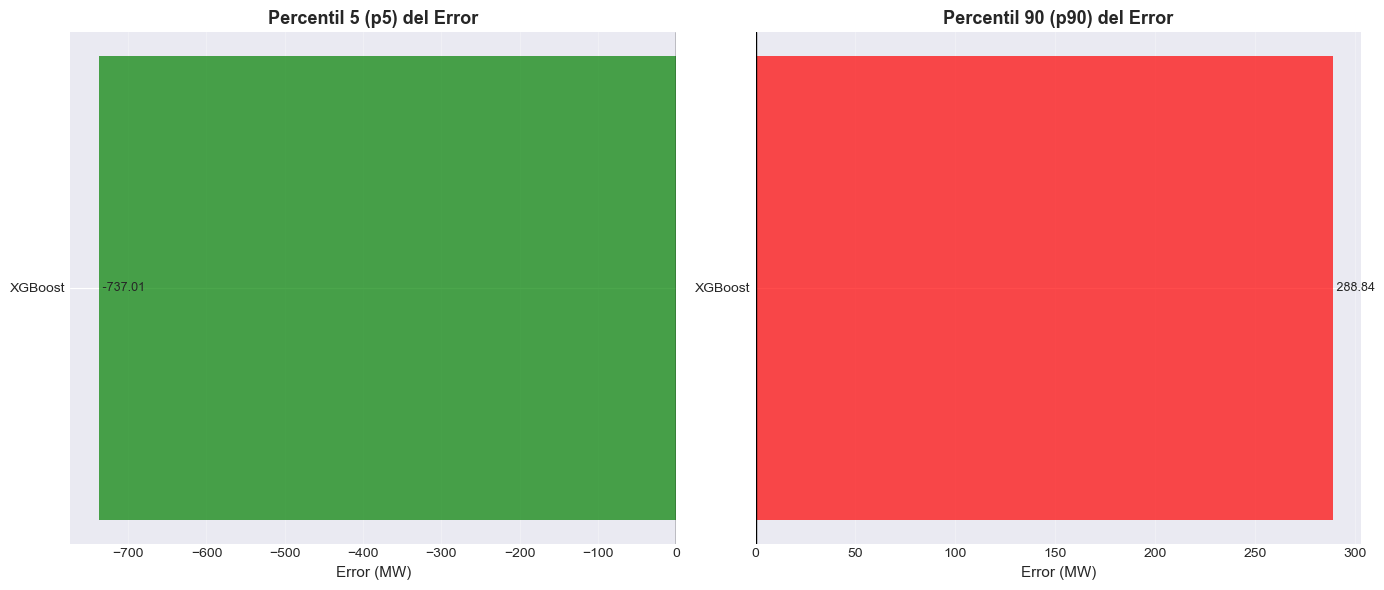

✓ Gráfico guardado en: artifacts/error_analysis/percentiles_errores_demanda.png

Resumen de Percentiles:


,Modelo,p5,p90,Rango (p90-p5)
0,XGBoost,-737.01,288.84,1025.85


In [16]:
# Visualización de percentiles p5 y p90
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Percentil 5
p5_values = [np.percentile(errors[name], 5) for name in errors.keys()]
model_names = list(errors.keys())

bars1 = ax1.barh(model_names, p5_values, color='green', alpha=0.7)
ax1.axvline(0, color='black', linestyle='-', linewidth=1)
ax1.set_title('Percentil 5 (p5) del Error', fontsize=13, fontweight='bold')
ax1.set_xlabel('Error (MW)', fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars1, p5_values)):
    ax1.text(val, i, f' {val:.2f}', va='center', fontsize=9)

# Percentil 90
p90_values = [np.percentile(errors[name], 90) for name in errors.keys()]

bars2 = ax2.barh(model_names, p90_values, color='red', alpha=0.7)
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.set_title('Percentil 90 (p90) del Error', fontsize=13, fontweight='bold')
ax2.set_xlabel('Error (MW)', fontsize=11)
ax2.grid(True, alpha=0.3, axis='x')

# Añadir valores en las barras
for i, (bar, val) in enumerate(zip(bars2, p90_values)):
    ax2.text(val, i, f' {val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(output_dir / 'percentiles_errores_demanda.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Gráfico guardado en: {output_dir / 'percentiles_errores_demanda.png'}")

# Tabla resumen de percentiles
print("\nResumen de Percentiles:")
percentiles_summary = pd.DataFrame({
    'Modelo': model_names,
    'p5': p5_values,
    'p90': p90_values,
    'Rango (p90-p5)': [p90 - p5 for p5, p90 in zip(p5_values, p90_values)]
})
display(percentiles_summary.round(2))


## 9. Resumen Final


In [17]:
print("="*80)
print("RESUMEN DEL ANÁLISIS DE ERRORES - DEMANDA ELÉCTRICA")
print("="*80)

print("\nMétricas principales (ordenadas por MAE):")
display(df_metrics[['Modelo', 'MAE', 'RMSE', 'p5', 'p90']].round(2))

print("\nMejor modelo según MAE:")
best_model = df_metrics.iloc[0]
print(f"  Modelo: {best_model['Modelo']}")
print(f"  MAE: {best_model['MAE']:.2f} MW")
print(f"  RMSE: {best_model['RMSE']:.2f} MW")
print(f"  p5: {best_model['p5']:.2f} MW")
print(f"  p90: {best_model['p90']:.2f} MW")

print(f"\n✓ Todos los resultados guardados en: {output_dir}")
print("="*80)


RESUMEN DEL ANÁLISIS DE ERRORES - DEMANDA ELÉCTRICA

Métricas principales (ordenadas por MAE):


,Modelo,MAE,RMSE,p5,p90
0,XGBoost,270.39,358.62,-737.01,288.84



Mejor modelo según MAE:
  Modelo: XGBoost
  MAE: 270.39 MW
  RMSE: 358.62 MW
  p5: -737.01 MW
  p90: 288.84 MW

✓ Todos los resultados guardados en: artifacts/error_analysis


## Notas para Ejecución en Google Colab

Si necesitas ejecutar este notebook en Google Colab, asegúrate de:

1. Subir los archivos necesarios:
   - Carpeta `artifacts/` completa
   - O al menos los modelos en `artifacts/trained_models/`
   - Y los datos en `artifacts/data/validation_models/`

2. Instalar dependencias:
```python
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost catboost lightgbm scipy
!pip install tensorflow  # Solo si quieres analizar modelos de redes neuronales
```

3. Ajustar las rutas según tu estructura de archivos en Colab
